In [1]:
# USAGE
# python train_mask_detector.py --dataset dataset

# import the necessary packages
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import glob
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
from PIL import Image

config = tensorflow.ConfigProto( device_count = {'GPU': 1 , 'CPU': 16} ) 
config.gpu_options.allow_growth = True
sess = tensorflow.Session(config=config) 
tensorflow.keras.backend.set_session(sess)

In [2]:
# construct the argument parser and parse the arguments
args = {'dataset':'/home/yoyo/Desktop/contrastive-predictive-coding/resources/dataset/',
        'model':'resnet50_01.model',
        'plot':'plot.png'}

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [3]:
print("[INFO] loading images...")

[INFO] loading images...


In [4]:
def _load_facemask(prefix="train", img_size=96):
    img_list = glob.glob('../data/facemask/' + prefix + '/**/*')
    np.random.shuffle(img_list)
    X_train = []
    for f in img_list:
        img = Image.open(f).resize((img_size, img_size))
        X_train.append(img)
    X_train = np.stack(X_train).astype("float32")
    y_train = np.array([f.split('/')[-2] for f in img_list])
    
    print("{} images".format(prefix))
    print(X_train.shape, X_train.dtype)
    print(y_train.shape)
    return X_train, y_train

In [5]:
# load facemask train data
trainX, trainY = _load_facemask("unlabeled")

unlabeled images
(3443, 96, 96, 3) float32
(3443,)


In [6]:
# load facemask test data
testX, testY = _load_facemask("test")

test images
(191, 96, 96, 3) float32
(191,)


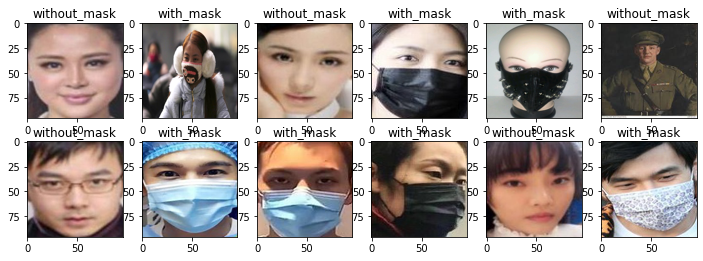

In [7]:
fig, axs = plt.subplots(nrows=2, ncols=6, constrained_layout=False, figsize=(12,4))

for i, ax in enumerate(axs.flat):
    ax.imshow(trainX[i] / 255.)
    ax.title.set_text(trainY[i])
plt.show()

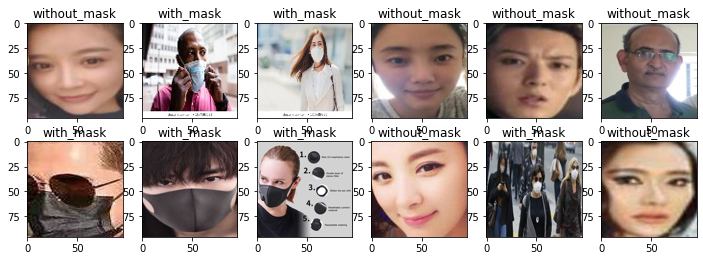

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=6, constrained_layout=False, figsize=(12,4))

for i, ax in enumerate(axs.flat):
    ax.imshow(testX[i] / 255.)
    ax.title.set_text(testY[i])
plt.show()

In [9]:
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
trainY = to_categorical(trainY)
testY = lb.transform(testY)
testY = to_categorical(testY)

In [10]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = ResNet50(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(96, 96, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(3, 3))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

print(model.summary())

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 102, 102, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 48, 48, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 48, 48, 64)   256         conv1_conv[0][0]                 
_____________

In [11]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS,
    verbose=2)

[INFO] training head...
Epoch 1/20
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
191/107 - 1s - loss: 0.5884 - acc: 0.7749
107/107 - 9s - loss: 0.5604 - acc: 0.7470 - val_loss: 0.5188 - val_acc: 0.7749
Epoch 2/20
Epoch 1/20
191/107 - 0s - loss: 0.3698 - acc: 0.8429
107/107 - 6s - loss: 0.3324 - acc: 0.8678 - val_loss: 0.3213 - val_acc: 0.8429
Epoch 3/20
Epoch 1/20
191/107 - 0s - loss: 0.3320 - acc: 0.8848
107/107 - 6s - loss: 0.2537 - acc: 0.9021 - val_loss: 0.2694 - val_acc: 0.8848
Epoch 4/20
Epoch 1/20
191/107 - 0s - loss: 0.2562 - acc: 0.9215
107/107 - 6s - loss: 0.2281 - acc: 0.9088 - val_loss: 0.1909 - val_acc: 0.9215
Epoch 5/20
Epoch 1/20
191/107 - 0s - loss: 0.3531 - acc: 0.8953
107/107 - 6s - loss: 0.2166 - acc: 0.9162 - val_loss: 0.2711 - val_acc: 0.8953
Epoch 6/20
Epoch 1/20
191/107 - 0s - loss: 0.4546 - acc: 0.8639
107/107 - 6s - loss: 0.1913 - acc: 0.9285 - val_loss: 0.3547 - val_acc: 0.8639
Epoch 7/20
Epoch 1/20
19

In [14]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_, digits=3))

[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask      1.000     0.849     0.918        86
without_mask      0.890     1.000     0.942       105

    accuracy                          0.932       191
   macro avg      0.945     0.924     0.930       191
weighted avg      0.939     0.932     0.931       191



In [15]:
lb.classes_

array(['with_mask', 'without_mask'], dtype='<U12')

[INFO] saving mask detector model...


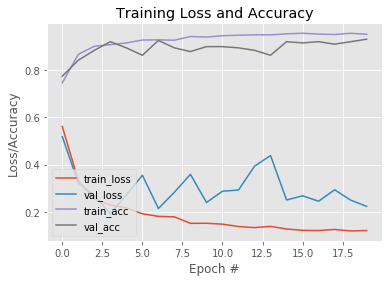

In [13]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save(args["model"], save_format="h5")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])